# Codon-specific ribosome density plots to detect ribosome pausing
 <p><div class="lev1 toc-item"><a href="#Import-&-annotate-data" ><span class="toc-item-num">1&nbsp;&nbsp;</span>Import & annotate data</a></div><div class="lev1 toc-item"><a href="#Analysis-for-Figure-1-/-Supp.-Figure-1"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis for Figure 1 / Supp. Figure 1</a></div><div class="lev1 toc-item"><a href="#Analysis-for-Figure-4-/-Supp.-Figure-4" ><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis for Figure 4 / Supp. Figure 4</a></div> 

# Import & annotate data

## Import libraries

In [2]:
library(BSgenome)  # genome manipulation
library(magrittr)  # nice piping operators
library(tidyverse)  # tables, plotting, read-write
library(Cairo)  # for pdf unicode export
library(stringr)  # string manipulation

# color blind palette
# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
cbPalette <- c("#666666", "#E69F00", "#56B4E9", 
               "#009E73", "#CC79A7", "#0072B2", "#D55E00", "#F0E442")

theme_set(theme_classic(base_family = "Helvetica", base_size = 8) +
theme(          
  strip.background = element_blank(),
  strip.text.x = element_text(size = 8),
  axis.line = element_line(size = .25),
  axis.ticks = element_line(size = .25),
  axis.text.x = element_text(size = 8),
  axis.text.y = element_text(size = 8),
  legend.text = element_text(size = 8)
))

celllinenames <- c(
  '293t' = '293T',
  'hct116' = 'HCT116',
  'hela' = 'HeLa'
)

starvnames <- c(
  'arg' = '–Arg',
  'leu' = "–Leu",
  'totalaa' = '–All AA',
  'torintor' = 'Torin1 > –Arg',
  'ltorin1tor' = '–Leu + Torin1 > –Arg', 
  'ltoar' = '–Leu > –Arg'
)

modificationnames <- c(
  'x293T' = '293T',
  'gcn2ko' = "GCN2 KO",
  'ragbq99l'= "+RagB Q99L",
  'ragbwt' = "+RagB WT",
  'hrgfp' = "+GFP",
  'wt' = "WT"
)

modificationumbers  <- c(
  "GCN2 KO" = 4,
  "+RagB Q99L" = 3,
  "+RagB WT" = 2,
  "+GFP" = 1,
  "WT" = 0)

drugnames <- c(
  'torin1' = "Torin1",
  'wt' = "DMSO"
)

drugnum <- c(
  "Torin1" = 1,
  "DMSO"  = 0
)

timenames <- c(
  '3h' = '3 hours',
  '6h' = '6 hours'
)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading required package: stats4

Attaching packag

## get filenames and sample names

In [2]:
# get all codon ribo density files
codonfiles <- list.files('../rawdata/ribo_profiling/processeddata/',
                         pattern = 'codon.ribo.density_overhang150.tsv',
                         recursive = T, full.names = T)

# parse sample names
samples  <- str_match(codonfiles, 'processeddata//(.*)/')[,2]
# get sample pairs for ribosome density diff calc
# these pairs are written in the '.org' file and exported to '.tsv'
samplepairs = read_tsv('../tables/samplepairs_codon_density.tsv')
samplepairs_supplement = read_tsv('../tables/samplepairs_codon_density_supplement1.tsv')
samplepairs_Fig1 = read_tsv('../tables/samplepairs_codon_density_Figure1.tsv')

Parsed with column specification:
cols(
  top = col_character(),
  bottom = col_character(),
  plotaa = col_character(),
  plotnumber = col_integer(),
  perturblevel = col_integer()
)
Parsed with column specification:
cols(
  top = col_character(),
  bottom = col_character(),
  plotaa = col_character(),
  plotnumber = col_integer(),
  perturblevel = col_integer()
)
Parsed with column specification:
cols(
  top = col_character(),
  bottom = col_character(),
  plotaa = col_character(),
  plotnumber = col_integer(),
  perturblevel = col_integer()
)


# A tibble: 8 x 5
               top            bottom plotaa plotnumber perturblevel
             <chr>             <chr>  <chr>      <int>        <int>
1    hct116_arg_3h    hct116_rich_3h      R          1            1
2    hct116_leu_3h    hct116_rich_3h      L          1            1
3 hela_arg_mono_3h hela_rich_mono_3h      R          1            1
4 hela_leu_mono_3h hela_rich_mono_3h      L          1            1
5  293t_rpC_arg_3h  293t_rpC_rich_3h      R          2            1
6  293t_rpC_leu_3h  293t_rpC_rich_3h      L          2            1
7  293t_rpC_arg_6h  293t_rpC_rich_3h      R          2            2
8      293t_leu_6h      293t_rich_6h      L          2            2


## set codon aa pairs

In [4]:
# set codon-aa pairings
codon.table  <- GENETIC_CODE %>% 
  as_tibble() %>%
  rownames_to_column(var='codon') %>%
  dplyr::rename(., aa=value) %>%
  arrange(aa) %>% 
  mutate(aanum = list <- c(1,1,1,2,2,2,2,3,3,4,4,5,5,6,6,7,7,7,7,8,8,9,9,9,10,10,11,11,11,11,11,11,12,13,13,14,14,14,14,15,15,16,16,16,16,16,16,17,17,17,17,17,17,18,18,18,18,19,19,19,19,20,21,21)) %>% 
  print

# A tibble: 64 x 3
   codon    aa aanum
   <chr> <chr> <dbl>
 1   TAA     *     1
 2   TAG     *     1
 3   TGA     *     1
 4   GCT     A     2
 5   GCC     A     2
 6   GCA     A     2
 7   GCG     A     2
 8   TGT     C     3
 9   TGC     C     3
10   GAT     D     4
# ... with 54 more rows


## assign an aa to each codon in ribosome density data 

In [5]:
data <- codonfiles %>% 
  # apply to each codon file
  lapply(. %>%
         # read file with first col as string
         read_tsv(col_types = c(col_character())) %>% 
         # gather all positions into single column
         gather(position, density, -codon) %>% 
         # convert position to integer
         mutate(position = as.integer(position))
        ) %>% 
  # give each sample the correct name
  set_names(samples) %>% 
  # join all sample data into one dataframe
  bind_rows(.id = 'sample') %>% 
  # add aa for each codon
  left_join(codon.table, by = 'codon') %>%
  print

# A tibble: 750,300 x 6
        sample codon position density    aa aanum
         <chr> <chr>    <int>   <dbl> <chr> <dbl>
 1 293t_arg_3h   TTT     -150  0.9957     F     6
 2 293t_arg_3h   TTC     -150  1.0143     F     6
 3 293t_arg_3h   TTA     -150  1.0510     L    11
 4 293t_arg_3h   TTG     -150  1.0301     L    11
 5 293t_arg_3h   TCT     -150  1.0205     S    17
 6 293t_arg_3h   TCC     -150  1.0020     S    17
 7 293t_arg_3h   TCA     -150  0.9867     S    17
 8 293t_arg_3h   TCG     -150  0.9233     S    17
 9 293t_arg_3h   TAT     -150  1.0709     Y    21
10 293t_arg_3h   TAC     -150  1.0779     Y    21
# ... with 750,290 more rows


# Analysis for Figure 1 / Supp. Figure 1

## pair samples & calculate density difference at each position

In [ ]:
pairsamples <- function(top, bottom, data) {
  # get all points for sample1
  df1 <- data %>% filter(sample == top)
  # get all points for sample2
  df2 <- data %>% filter(sample == bottom)
  df <- df1 %>%
    # join both data frames
    inner_join(df2, by=c("aa","aanum", "codon", "position")) %>% 
    # calculate density difference
    mutate(density.diff=density.x-density.y)
  df
}

density.diff  <- map2(samplepairs_Fig1[['top']], 
                      samplepairs_Fig1[['bottom']], 
                      pairsamples, data) %>% 
  bind_rows %>% 
  # join with samplepairs to get plot number and plot aa
  left_join(samplepairs_Fig1, by = c("sample.x" = "top", "sample.y" = "bottom")) %>%
  # extract annotations for easy plotting
  mutate(cellline=str_extract(sample.x, '293t|hela|hct116'),
         starv=str_extract(sample.x, 'arg|leu'),
         time=str_extract(sample.x, '3h|6h')) %>% 
  write_tsv('../tables/codon.density.diff.fig1.tsv') #%>% 
  #print

density.diff$codon <- str_replace_all(density.diff$codon, "T", "U")

## sum density diff over entire window

In [12]:
density.diff.sum <- density.diff %>% 
  group_by(codon, aa, aanum, sample.x, sample.y) %>% 
  select(density.diff) %>% 
  summarise(density.sum = sum(density.diff)) %>%  
  # join with samplepairs to get plot number and plot aa
  left_join(samplepairs_Fig1, by = c("sample.x" = "top", "sample.y" = "bottom")) %>%
  # extract annotations for easy plotting
  mutate(cellline=str_extract(sample.x, '293t|hela|hct116'),
         starv=str_extract(sample.x, 'arg|leu'),
         time= str_extract(sample.x, '3h|6h'),
         samplepair = paste0(sample.x, ' – ', sample.y)) %>% 
  ungroup %>%
  arrange(samplepair, codon) %>%
  write_tsv('../tables/codon.density.diff.sum.fig1.tsv')

Adding missing grouping variables: `codon`, `aa`, `aanum`, `sample.x`, `sample.y`


## plot summed density difference for all codons across entire window (fig. 1a & supp. fig. 1h)

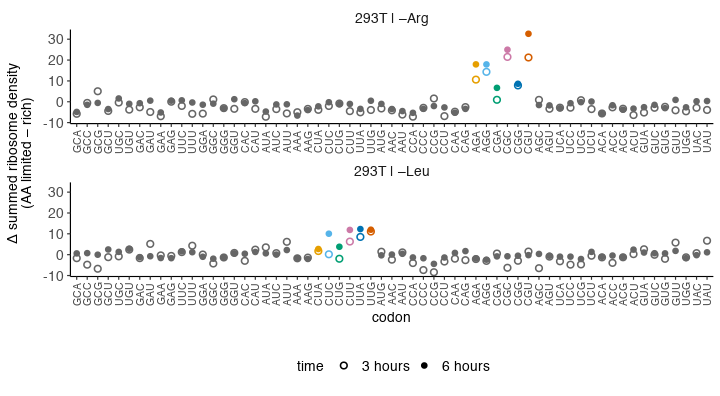

In [245]:
options(repr.plot.width = 6, repr.plot.height = 3.3)
options(warn=-1)
p <- density.diff.sum %>% filter(plotnumber == 2) %>% 
  mutate(cellline = celllinenames[cellline], starv = starvnames[starv], time = timenames[time]) %>%
  mutate(panels = paste(cellline, '|', starv)) %>% 
  mutate(panels = forcats::fct_reorder(panels, aanum, .desc = T)) %>% 
  mutate(codoncolor = ifelse(plotaa == aa, codon, '0')) %>% 
  ggplot(aes(x = forcats::fct_reorder(codon, aanum), y = density.sum, 
             color = codoncolor, shape = time))

p + geom_point(size=1.25) + facet_wrap(~panels, ncol = 1, scales = "free_x") + 
  scale_shape_manual(values=c(1,16)) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5,size=6)) + 
  # set colors manually
  scale_colour_manual(values=c(cbPalette[1], rep(cbPalette[2:7], 2))) +
  theme(legend.position="bottom") +
  labs(x = 'codon',
       y = 'Δ summed ribosome density\n(AA limited \u2013 rich)') +
  guides(color=FALSE)


ggsave('../figures/suppfig1_293t_timecourse_v2.pdf',
       width = 6, height = 3.3,units = 'in', device = cairo_pdf)

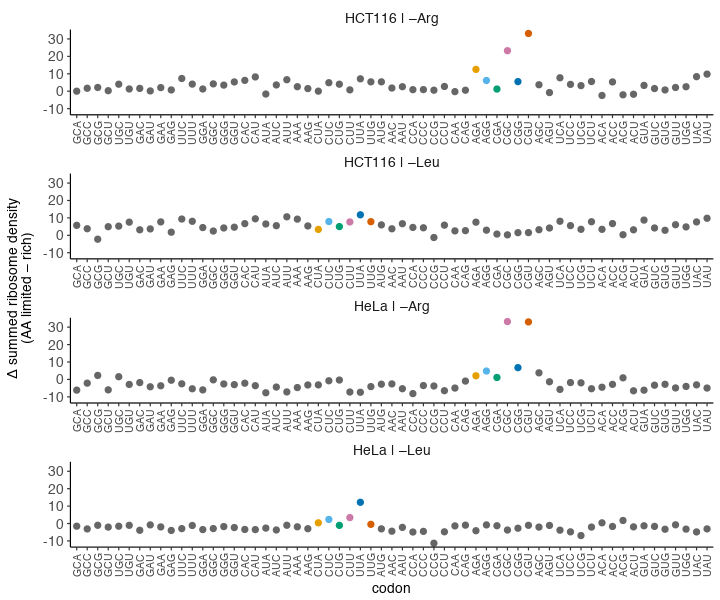

In [205]:
options(repr.plot.width = 6, repr.plot.height = 5)
options(warn=-1)
p <- density.diff.sum %>%
  mutate(cellline = celllinenames[cellline], starv = starvnames[starv], time= timenames[time]) %>%
  mutate(panels = paste(cellline, " | ", starv, sep = "")) %>% 
  mutate(panels = forcats::fct_reorder(panels, aanum, .desc = T)) %>% 
  mutate(codoncolor = ifelse(plotaa == aa, codon, '0')) %>% 
  filter(plotnumber == 1) %>%
  ggplot(aes(x = forcats::fct_reorder(codon, aanum), y = density.sum, 
             color = codoncolor))

p + geom_point(size=1) + facet_wrap(~panels, ncol = 1, scales = "free_x") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) + 
  # set colors manually
  scale_colour_manual(values=c(cbPalette[1], rep(cbPalette[2:7], 2))) +
  theme(legend.position="none", 
        axis.text.x = element_text(size=6)) +
  labs(x = 'codon',
       y = 'Δ summed ribosome density\n(AA limited \u2013 rich)')


ggsave('../figures/suppfig1_helahct116.pdf',
       width = 6, height = 5,units = 'in', device = cairo_pdf)

## plot density difference for arginine/leucine codons at each position in window (fig. 1b,c)

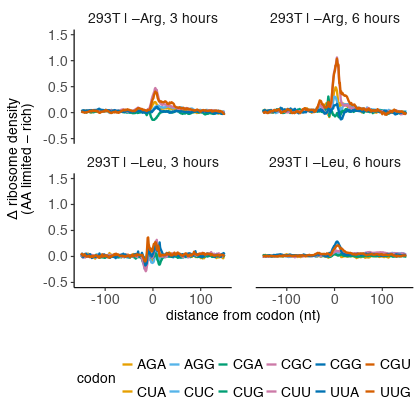

In [17]:
options(repr.plot.width = 3.5, repr.plot.height = 3.5)

p <- density.diff %>% 
  filter(plotnumber == 2 & plotaa == aa)  %>% 
  arrange(starv) %>% 
  mutate(cellline = celllinenames[cellline], starv = starvnames[starv], time = timenames[time]) %>%
  mutate(panels = paste(cellline, ' | ', starv, ', ', time, sep='')) %>% 
  mutate(panels = forcats::fct_reorder(panels, aanum, .desc=T)) %>% 
  ggplot(aes(x = position, y = density.diff, color = codon)) +
  geom_line() +
  facet_wrap(~ panels, ncol = 2) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette[2:7], 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.5, 1.5)) +
  xlab('distance from codon (nt)') + 
  ylab('Δ ribosome density\n(AA limited \u2013 rich)') +
  theme(panel.spacing.x = unit(1, "lines"),
        legend.key.size = unit(1, 'lines'),
        legend.position = "bottom"
       ) +
  guides(color = guide_legend(ncol = 6, title.hjust = 0.5, keywidth = 0.5,
                              byrow = TRUE))

p

ggsave('../figures/fig1_293t_timecourse.pdf',
       width = 3.5, height = 3.5, units = 'in', device = cairo_pdf)
#ggsave('../figures/fig1_293t_timecourse.png',
       #width = 3.5, height = 3.5, units = 'in')

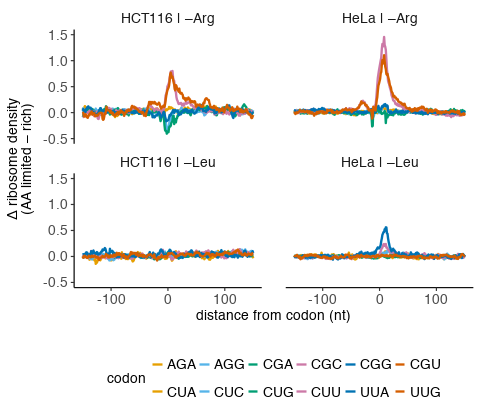

In [15]:
options(repr.plot.width = 4, repr.plot.height = 3.5)

p <- density.diff %>% 
  filter(plotnumber == 1 & plotaa == aa)  %>% 
  mutate(cellline = celllinenames[cellline], starv = starvnames[starv]) %>%
  mutate(panels = paste(cellline, " | ", starv, sep = "")) %>% 
  arrange(starv) %>% 
  mutate(panels = forcats::fct_reorder(panels, aanum, .desc = T)) %>% 
  ggplot(aes(x = position, y = density.diff, color = codon)) +
  geom_line() +
  facet_wrap(~ panels, ncol = 2) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette[2:7], 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.5, 1.5)) +
  xlab('distance from codon (nt)') + 
  ylab('Δ ribosome density\n(AA limited \u2013 rich)') +
  theme(panel.spacing.x = unit(1, "lines"),
        legend.key.size = unit(1, 'lines'),
        legend.position = "bottom"
       ) +
  guides(color = guide_legend(ncol = 6, title.hjust = 0.5, keywidth = 0.5,
                              byrow = TRUE))

p

ggsave('../figures/fig1_hct116hela.pdf',
       width = 3.5, height = 3.5,units = 'in', device = cairo_pdf)

# Analysis for Figure 4 / Supp. Figure 4

In [18]:
pairsamples <- function(top, bottom, data) {
  # get all points for sample1
  df1 <- data %>% filter(sample == top)
  # get all points for sample2
  df2 <- data %>% filter(sample == bottom)
  df <- df1 %>%
    # join both data frames
    inner_join(df2, by=c("aa","aanum", "codon", "position")) %>% 
    # calculate density difference
    mutate(density.diff=density.x-density.y)
  df
}

density.diff  <- map2(samplepairs[['top']], 
                      samplepairs[['bottom']], 
                      pairsamples, data) %>% 
  bind_rows %>% 
  # join with samplepairs to get plot number and plot aa
  left_join(samplepairs, by = c("sample.x" = "top", "sample.y" = "bottom")) %>%
  # extract annotations for easy plotting
  mutate(cellline=str_extract(sample.x, '293t'),
         starv=str_extract(sample.x, 'arg|leu'),
         modification=str_extract(sample.x, 'gcn2ko|hrgfp|ragbq99l'),
         drug=str_extract(sample.x, 'torin1'), time= str_extract(sample.x, '3h|6h')) 
  #print

density.diff$codon <- str_replace_all(density.diff$codon, "T", "U") 

In [19]:
density.diff.sum <- density.diff %>% 
  group_by(codon, aa, aanum, sample.x, sample.y) %>% 
  select(density.diff) %>% 
  summarise(density.sum = sum(density.diff)) %>%  
  # join with samplepairs to get plot number and plot aa
  left_join(samplepairs, by = c("sample.x" = "top", "sample.y" = "bottom")) %>%
  # extract annotations for easy plotting
  mutate(cellline=str_extract(sample.x, '293t'),
         starv=str_extract(sample.x, 'arg|leu'),
         modification=str_extract(sample.x, 'gcn2ko|hrgfp|ragbq99l'),
         time= str_extract(sample.x, '3h|6h'), drug=str_extract(sample.x, 'torin1'),
         samplepair = paste0(sample.x, ' – ', sample.y)) %>% 
  ungroup %>%
  arrange(samplepair, codon) #%>%
  #write_tsv('../tables/codon.density.diff.sum.tsv') #%>% 
  #print

Adding missing grouping variables: `codon`, `aa`, `aanum`, `sample.x`, `sample.y`


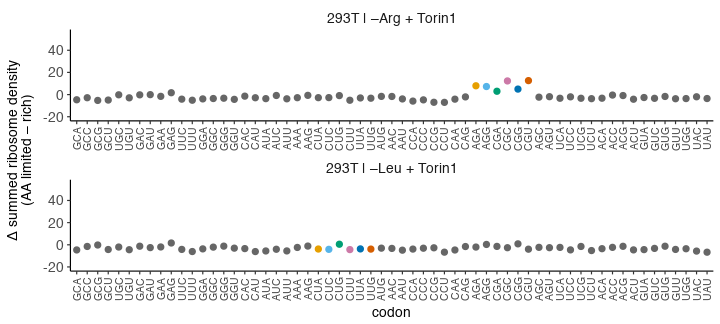

In [314]:
options(repr.plot.width = 6, repr.plot.height = 2.7)
options(warn=-1)
p <- density.diff.sum %>%
  mutate(cellline = celllinenames[cellline], starv = starvnames[starv], drug = drugnames[drug]) %>%
  mutate(panels = paste(cellline, " | ", starv, " + ", drug, sep = "")) %>% 
  mutate(panels = forcats::fct_reorder(panels, aanum, .desc = T)) %>% 
  mutate(codoncolor = ifelse(plotaa == aa, codon, '0')) %>% 
  filter(plotnumber == 3) %>% 
  ggplot(aes(x = forcats::fct_reorder(codon, aanum), y = density.sum, 
             color = codoncolor))

p + geom_point(size=1) + facet_wrap(~panels, ncol = 1, scales = "free_x") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) + 
  # set colors manually
  scale_colour_manual(values=c(cbPalette[1], rep(cbPalette[2:7], 2))) +
  ylim(-20,55) +
  theme(legend.position="none", 
        axis.text.x = element_text(size=6)) +
  labs(x = 'codon',
       y = 'Δ summed ribosome density\n(AA limited \u2013 rich)')

ggsave('../figures/suppfig4b.pdf',
       width = 6, height = 2.7,units = 'in', device = cairo_pdf)

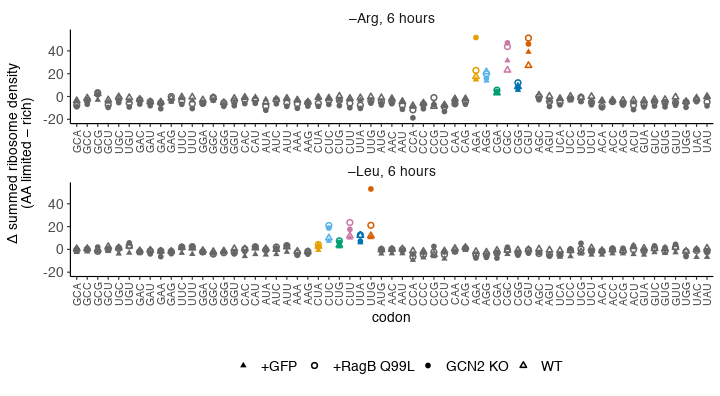

In [313]:
options(repr.plot.width = 6, repr.plot.height = 3.3)
options(warn=-1)
p <- density.diff.sum %>%   mutate(modification = ifelse(is.na(modification), "wt", modification)) %>% 
  mutate(cellline = celllinenames[cellline], starv = starvnames[starv], modification = modificationnames[modification], time = timenames[time]) %>%
  mutate(panels = paste(starv, ', ', time, sep = "")) %>%   mutate(panelnum = -10*aanum + modificationumbers[modification]) %>% 
  mutate(panels = forcats::fct_reorder(panels, panelnum, .desc = F)) %>% 
  mutate(codoncolor = ifelse(plotaa == aa, codon, '0')) %>% 
  filter(plotnumber == 2) %>% 
  ggplot(aes(x = forcats::fct_reorder(codon, aanum), y = density.sum, 
             color = codoncolor, shape = modification))

p + geom_point(size=1) + facet_wrap(~panels, ncol = 1, scales = "free_x") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) + 
  # set colors manually
  scale_colour_manual(values=c(cbPalette[1], rep(cbPalette[2:7], 2))) +
  scale_shape_manual(values=c(17,1,16,2)) +
  ylim(-20,55) +
  theme(legend.position = 'bottom',axis.text.x = element_text(size=6)) + guides(color = FALSE) + guides(shape=guide_legend(title="")) +
  labs(x = 'codon',
       y = 'Δ summed ribosome density\n(AA limited \u2013 rich)')

ggsave('../figures/suppfig4f.pdf',
      width = 6, height = 3.3,units = 'in', device = cairo_pdf)

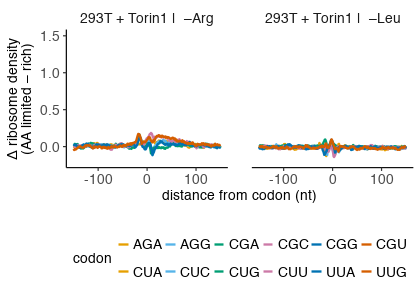

In [23]:
options(repr.plot.width = 3.5, repr.plot.height = 2.5)

p <- density.diff %>% 
  filter(plotnumber == 3 & plotaa == aa)  %>% 
  arrange(starv) %>% 
  mutate(drug = drugnames[drug], 
         starv = paste("293T + Torin1 | ", starvnames[starv])) %>%
  ggplot(aes(x = position, y = density.diff, color = codon)) +
  geom_line() +
  facet_wrap(~ starv, ncol = 2) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette[2:7], 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.2, 1.5)) +
  xlab('distance from codon (nt)') + 
  ylab('Δ ribosome density\n(AA limited \u2013 rich)') +
  theme(panel.spacing.x = unit(1, "lines"),
        legend.key.size = unit(1, 'lines'),
        legend.position = "bottom"
       ) +
  guides(color = guide_legend(ncol = 6, title.hjust = 0.5, keywidth = 0.5,
                              byrow = TRUE))

p

ggsave('../figures/fig4b.pdf',
       width = 3.5, height = 2.5, units = 'in', device = cairo_pdf)

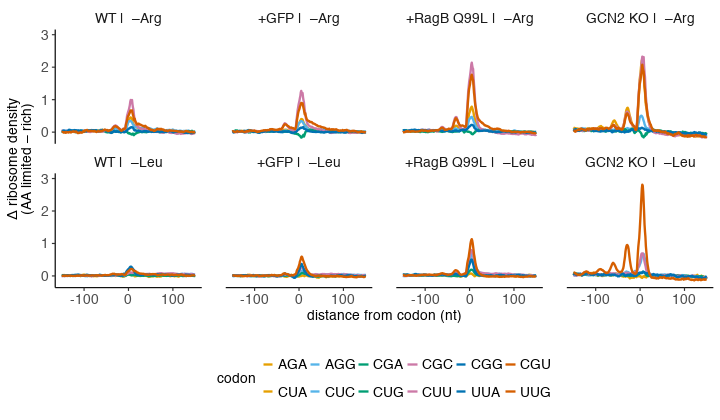

In [10]:
options(repr.plot.width = 6, repr.plot.height = 3.5)
options(warn=-1)
p <- density.diff %>% 
  filter(plotnumber == 2 & plotaa == aa)  %>% 
  mutate(modification = ifelse(is.na(modification), "wt", modification)) %>% 
  arrange(starv) %>% 
  mutate(modification = modificationnames[modification], 
         starv = starvnames[starv]) %>%
  mutate(panelnum = -10*aanum + modificationumbers[modification]) %>% 
  mutate(panels = paste(modification, "| ", starv)) %>% 
  mutate(panels = forcats::fct_reorder(panels, panelnum)) %>% 
  ggplot(aes(x = position, y = density.diff, color = codon)) +
  geom_line() +
  facet_wrap(~ panels, ncol = 4) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette[2:7], 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.2, 3)) +
  xlab('distance from codon (nt)') + 
  ylab('Δ ribosome density\n(AA limited \u2013 rich)') +
  theme(panel.spacing.x = unit(1, "lines"),
        legend.key.size = unit(1, 'lines'),
        legend.position = "bottom"
       ) +
  guides(color = guide_legend(ncol = 6, title.hjust = 0.5, keywidth = 0.5,
                              byrow = TRUE))

p

ggsave('../figures/fig4f.pdf',
       width = 6, height = 3.5, units = 'in', device = cairo_pdf)

In [ ]:
pairsamples <- function(top, bottom, data) {
  # get all points for sample1
  df1 <- data %>% filter(sample == top)
  # get all points for sample2
  df2 <- data %>% filter(sample == bottom)
  df <- df1 %>%
    # join both data frames
    inner_join(df2, by=c("aa","aanum", "codon", "position")) %>% 
    # calculate density difference
    mutate(density.diff=density.x-density.y)
  df
}

density.diff  <- map2(samplepairs_supplement[['top']], 
                      samplepairs_supplement[['bottom']], 
                      pairsamples, data) %>% 
  bind_rows %>% 
  # join with samplepairs to get plot number and plot aa
  left_join(samplepairs_supplement, by = c("sample.x" = "top", "sample.y" = "bottom")) %>%
  # extract annotations for easy plotting
  mutate(cellline=str_extract(sample.x, '293t|hela|hct116'),
         starv=str_extract(sample.x, 'arg|leu|ltoar|ltorin1tor|torintor|totalaa'),
         modification=str_extract(sample.x, 'gcn2ko|hrgfp|ragbq99l|ragbwt'),
         drug=str_extract(sample.x, 'torin1')) 
  #print

density.diff$codon <- str_replace_all(density.diff$codon, "T", "U") 

In [127]:
density.diff.sum <- density.diff %>% 
  group_by(codon, aa, aanum, sample.x, sample.y) %>% 
  select(density.diff) %>% 
  summarise(density.sum = sum(density.diff)) %>%  
  # join with samplepairs to get plot number and plot aa
  left_join(samplepairs_supplement, by = c("sample.x" = "top", "sample.y" = "bottom")) %>%
  # extract annotations for easy plotting
   mutate(cellline=str_extract(sample.x, '293t|hela|hct116'),
         starv=str_extract(sample.x, 'arg|leu|ltoar|ltorin1tor|torintor|totalaa'),
         modification=str_extract(sample.x, 'gcn2ko|hrgfp|ragbq99l|ragbwt'),
         drug=str_extract(sample.x, 'torin1'),
         samplepair = paste0(sample.x, ' – ', sample.y)) %>% 
  ungroup %>%
  arrange(samplepair, codon) %>%
  write_tsv('../tables/codon.density.diff.sum.supplement.tsv') #%>% 
  #print

Adding missing grouping variables: `codon`, `aa`, `aanum`, `sample.x`, `sample.y`


function (x, ...) 
UseMethod("print")
<bytecode: 0x7fb351b33a60>
<environment: namespace:base>

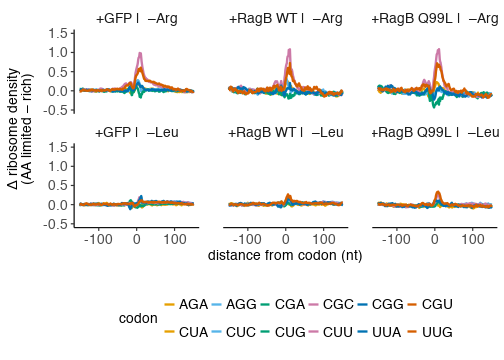

In [37]:
options(repr.plot.width = 4.2, repr.plot.height = 3)

p <- density.diff %>% 
  filter(plotnumber == 1 & plotaa == aa)  %>% 
  mutate(modification = ifelse(is.na(modification), "wt", modification)) %>% 
  arrange(starv) %>% 
  mutate(modification = modificationnames[modification], 
         starv = starvnames[starv]) %>%
  mutate(panelnum = -10*aanum + modificationumbers[modification]) %>% 
  mutate(panels = paste(modification, "| ", starv)) %>% 
  mutate(panels = forcats::fct_reorder(panels, panelnum)) %>% 
  ggplot(aes(x = position, y = density.diff, color = codon)) +
  geom_line() +
  facet_wrap(~ panels, ncol = 3) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette[2:7], 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.5, 1.5)) +
  xlab('distance from codon (nt)') + 
  ylab('Δ ribosome density\n(AA limited \u2013 rich)') +
  theme(panel.spacing.x = unit(1, "lines"),
        legend.key.size = unit(1, 'lines'),
        legend.position = "bottom"
       ) +
  guides(color = guide_legend(ncol = 6, title.hjust = 0.5, keywidth = 0.5,
                              byrow = TRUE))

p

ggsave('../figures/suppfig4_tbd_2.pdf',
       width = 4.2, height = 3,units = 'in', device = cairo_pdf)

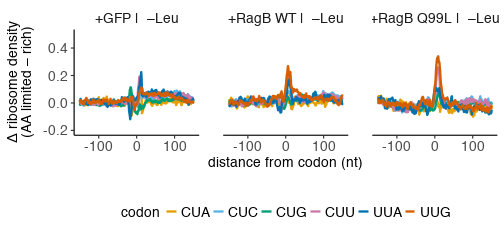

In [46]:
options(repr.plot.width = 4.2, repr.plot.height = 2)

p <- density.diff %>% 
  filter(plotnumber == 2 & plotaa == aa)  %>% 
  mutate(modification = ifelse(is.na(modification), "wt", modification)) %>% 
  arrange(starv) %>% 
  mutate(modification = modificationnames[modification], 
         starv = starvnames[starv]) %>%
  mutate(panelnum = -10*aanum + modificationumbers[modification]) %>% 
  mutate(panels = paste(modification, "| ", starv)) %>% 
  mutate(panels = forcats::fct_reorder(panels, panelnum)) %>% 
  ggplot(aes(x = position, y = density.diff, color = codon)) +
  geom_line() +
  facet_wrap(~ panels, ncol = 3) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette[2:7], 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.2, .5)) +
  xlab('distance from codon (nt)') + 
  ylab('Δ ribosome density\n(AA limited \u2013 rich)') +
  theme(panel.spacing.x = unit(1, "lines"),
        legend.key.size = unit(1, 'lines'),
        legend.position = "bottom"
       ) +
  guides(color = guide_legend(ncol = 6, title.hjust = 0.5, keywidth = 0.5,
                              byrow = TRUE))

p

ggsave('../figures/suppfig4_tbd_3.pdf',
       width = 4.2, height = 2,units = 'in', device = cairo_pdf)